In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [2]:
!mkdir celeba_gan
!wget "https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t" -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

mkdir: cannot create directory ‘celeba_gan’: File exists
--2023-12-20 16:28:00--  https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t
Resolving drive.google.com (drive.google.com)... 108.177.98.101, 108.177.98.102, 108.177.98.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.98.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6592q8nas4ov9nis83lptrtm19uk56sh/1703089650000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=fbe8dc38-3e10-4c6a-b623-9ab39a09d547 [following]
--2023-12-20 16:28:01--  https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6592q8nas4ov9nis83lptrtm19uk56sh/1703089650000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=fbe8dc38-3e10-4c6a-b623-9ab39a09d547
Resolving doc-04-a4-docs.googleusercontent.com (doc-04-a4-docs.googleusercontent.

In [3]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.


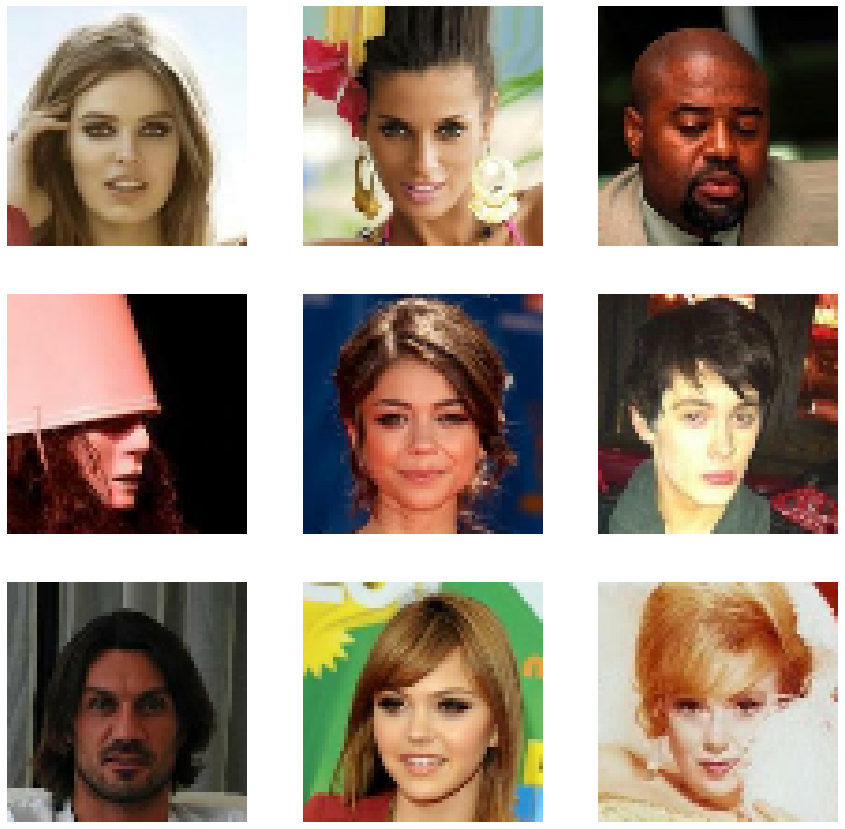

In [5]:
import matplotlib.pyplot as plt
for images in dataset.take(1):
    # Display the images
    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

In [6]:
dataset = dataset.map(lambda x: x / 255.)

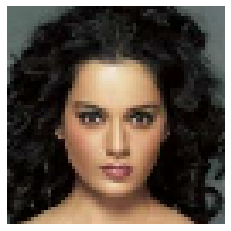

In [7]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [8]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [9]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

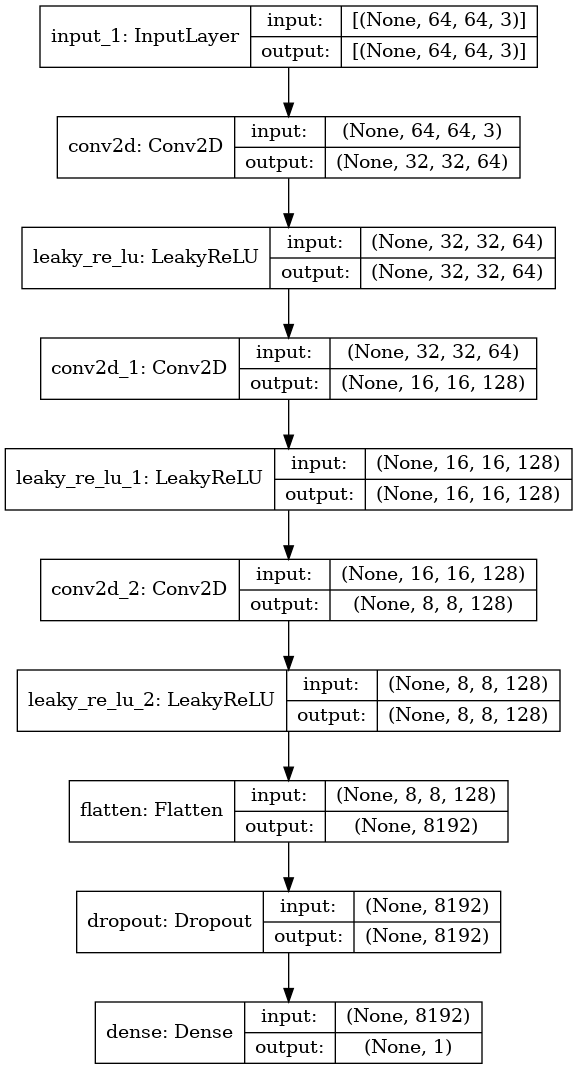

In [10]:
from tensorflow.keras import utils

utils.plot_model(discriminator, show_shapes =True)

In [11]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

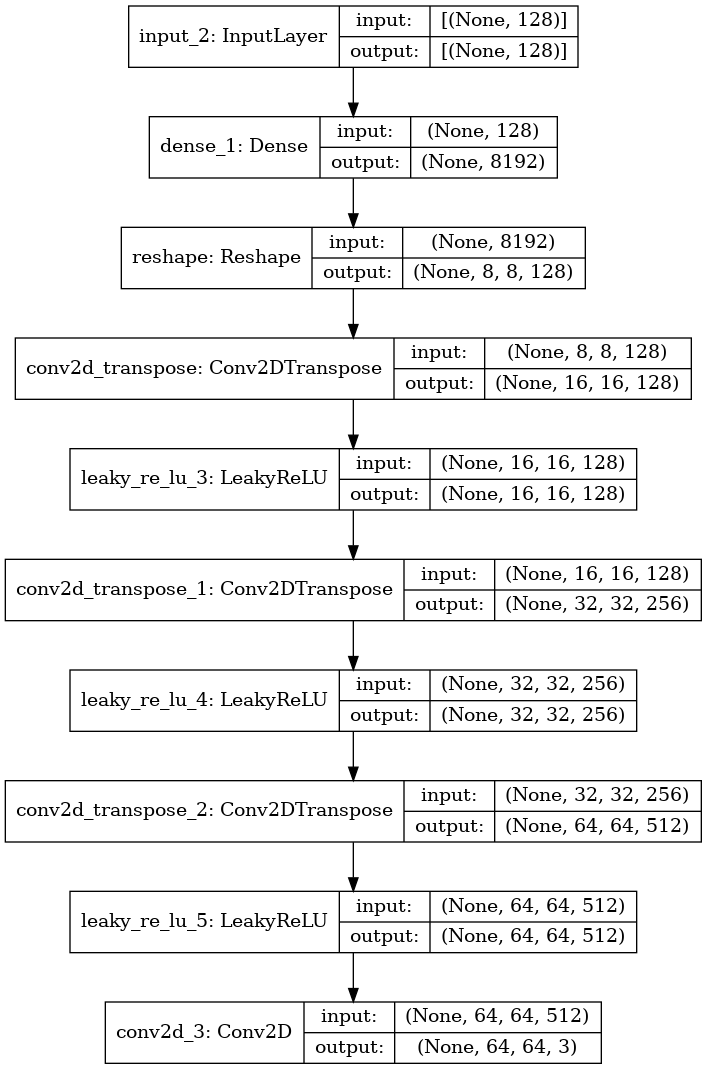

In [13]:
utils.plot_model(generator, show_shapes =True)

In [14]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [16]:
# 코랩에서 정상 실행만 확인하기 위해 에포크 횟수를 10으로 줄입니다
epochs = 20 # 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
with tf.device('/GPU:0'):
    gan.fit(
        dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    )

Epoch 1/20
6332/6332 [==============================] - 1811s 279ms/step - d_loss: 0.6116 - g_loss: 1.2228
Epoch 2/20
6332/6332 [==============================] - 1777s 281ms/step - d_loss: 0.6573 - g_loss: 1.0519
Epoch 3/20
6332/6332 [==============================] - 1774s 280ms/step - d_loss: 0.6598 - g_loss: 1.0161
Epoch 4/20
6332/6332 [==============================] - 1777s 281ms/step - d_loss: 0.6639 - g_loss: 1.0067
Epoch 5/20
6332/6332 [==============================] - 1776s 280ms/step - d_loss: 0.6499 - g_loss: 1.0455
Epoch 6/20
6332/6332 [==============================] - 1776s 280ms/step - d_loss: 0.6547 - g_loss: 0.9839
Epoch 7/20
6332/6332 [==============================] - 1771s 280ms/step - d_loss: 0.6635 - g_loss: 0.9645
Epoch 8/20
6332/6332 [==============================] - 1773s 280ms/step - d_loss: 0.6649 - g_loss: 0.9287
Epoch 9/20
6332/6332 [==============================] - 1774s 280ms/step - d_loss: 0.6656 - g_loss: 0.9201
Epoch 10/20
6332/6332 [==============

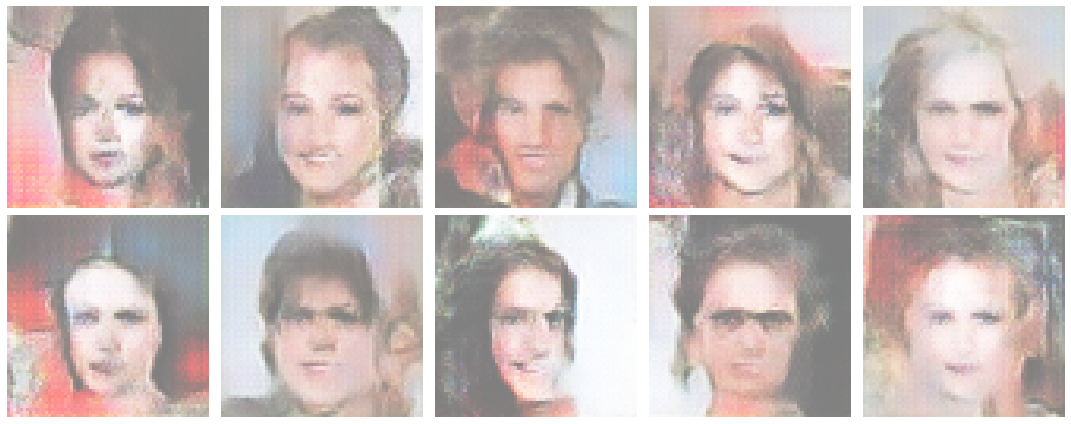

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_generated_images(generator, latent_dim, num_images=10):
    # 랜덤한 잠재 벡터 샘플링
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))

    # 생성자에 의해 이미지 생성
    generated_images = generator.predict(random_latent_vectors)

    # 생성된 이미지 플로팅
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i] * 0.5 + 0.5)  # 픽셀 값 범위를 [0, 1]로 조정
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 생성된 이미지 플로팅
plot_generated_images(generator, latent_dim)

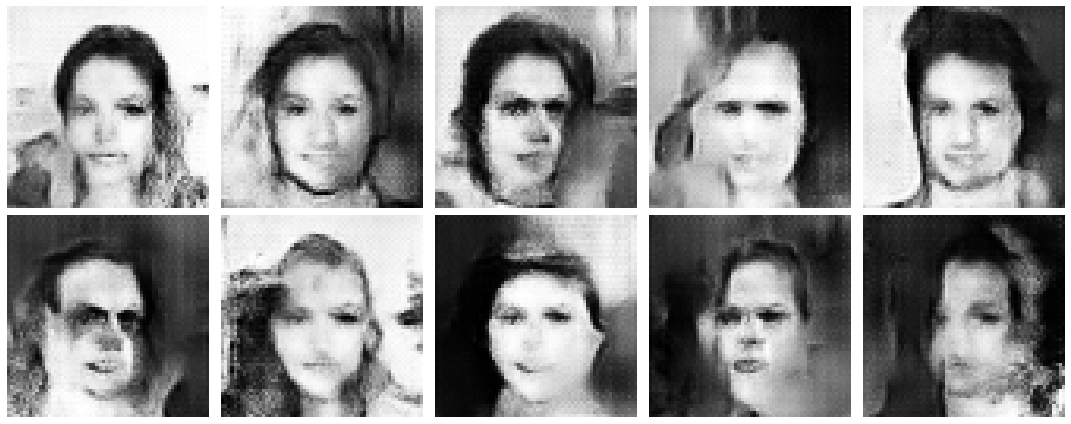

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 생성된 이미지 수
num_generated_images = 10

# 잠재 공간에서 랜덤한 포인트 샘플링
random_latent_vectors = np.random.normal(size=(num_generated_images, latent_dim))

# 생성자에 의해 이미지 생성
generated_images = generator.predict(random_latent_vectors)

# 생성된 이미지 플로팅
plt.figure(figsize=(15, 6))
for i in range(num_generated_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()